### 0. Set up

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk import ngrams
from collections import Counter

### 1. Data loading

In [ ]:
#unhashtag to install PyDrive
#!pip install -U -q PyDrive

In [ ]:
#import dataset from GoogleDrive set up
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#please authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#read csv from google drive
train_link = 'https://drive.google.com/file/d/1bT0zLVHRmHoPolqXhbcE5kYtMPmDyPJ0/view?usp=drive_link'
downloaded = drive.CreateFile({'id':"1bT0zLVHRmHoPolqXhbcE5kYtMPmDyPJ0"})
downloaded.GetContentFile('train.csv')
train_data = pd.read_csv('train.csv')

dev_link = 'https://drive.google.com/file/d/12Utd1Y_lEl0hfgu8bOn_0wPxB62DWl99/view?usp=sharing'
downloaded = drive.CreateFile({'id':"12Utd1Y_lEl0hfgu8bOn_0wPxB62DWl99"})
downloaded.GetContentFile('validation.csv')
dev_data = pd.read_csv('validation.csv')

test_link = 'https://drive.google.com/file/d/1Yu8LHIumo96DbyuFIRylfUv6bnfK2PYk/view?usp=sharing'
downloaded = drive.CreateFile({'id':"1Yu8LHIumo96DbyuFIRylfUv6bnfK2PYk"})
downloaded.GetContentFile('test.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
train_data.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
dev_data.head()

,id,article,highlights
0,61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3,"Sally Forrest, an actress-dancer who graced th...","Sally Forrest, an actress-dancer who graced th..."
1,21c0bd69b7e7df285c3d1b1cf56d4da925980a68,A middle-school teacher in China has inked hun...,Works include pictures of Presidential Palace ...
2,56f340189cd128194b2e7cb8c26bb900e3a848b4,A man convicted of killing the father and sist...,"Iftekhar Murtaza, 29, was convicted a year ago..."
3,00a665151b89a53e5a08a389df8334f4106494c2,Avid rugby fan Prince Harry could barely watch...,Prince Harry in attendance for England's crunc...
4,9f6fbd3c497c4d28879bebebea220884f03eb41a,A Triple M Radio producer has been inundated w...,Nick Slater's colleagues uploaded a picture to...


In [ ]:
test_data.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


#### Data Analytics

Overlap between true summary and article with respect to the index of sentence

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def count_overlap(row):
    summary = row["highlights"]
    sentences = sent_tokenize(row["article"])

    v0 = set(summary.split())

    overlap = []
    for sent in sentences:
        v1 = set(sent.split())
        overlap.append(len(v1.intersection(v0)))
    # print(overlap)
    return overlap

train_data["overlap_count"] = train_data.apply(lambda x: count_overlap(x), axis=1)
train_data["overlap_count"].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0      [1, 1, 1, 1, 1, 1, 1, 11, 2, 14, 2, 9, 8, 2, 5]
1    [5, 5, 9, 6, 1, 5, 6, 5, 1, 2, 1, 1, 3, 3, 4, ...
2    [7, 8, 9, 12, 2, 3, 11, 14, 6, 3, 7, 6, 6, 1, ...
3    [5, 0, 5, 1, 8, 3, 6, 5, 2, 2, 6, 7, 0, 10, 14...
4    [12, 8, 11, 2, 3, 3, 5, 7, 4, 5, 6, 5, 2, 5, 4...
Name: overlap_count, dtype: object

In [ ]:
arr = train_data["overlap_count"].to_numpy()
max_len = 0

count_map = {}
for i in range(len(arr)):
    l = len(arr[i])
    if l > max_len:
        max_len = l
    for j in range(l):
        arr[i] = np.array(arr[i])
        if j not in count_map:
            count_map[j] = []
        count_map[j].append(arr[i][j])

avg_overlaps = np.zeros(max_len)
for j in range(max_len):
    if j in count_map:
        avg_overlaps[j] = np.mean(count_map[j])

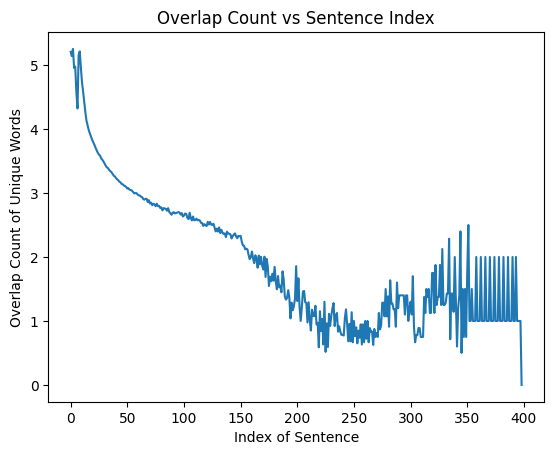

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(max_len), avg_overlaps)
plt.xlabel("Index of Sentence")
plt.ylabel("Overlap Count of Unique Words")
plt.title("Overlap Count vs Sentence Index")
plt.show()

### 2. Evaluation Metrics

The ROUGE-N score is a metric commonly used in natural language processing to evaluate the quality of machine-generated text by comparing it to a set of reference texts. It measures the overlap of n-grams between the generated text and the reference text.

In [ ]:
def rouge_score(candidate, reference, n):

    candidate_ngrams = list(ngrams(candidate.split(), n))
    reference_ngrams = list(ngrams(reference.split(), n))

    # Calculate the overlap of n-grams
    overlap_count = len(set(candidate_ngrams) & set(reference_ngrams))

    # Calculate precision, recall, and F1 score
    precision = overlap_count / len(candidate_ngrams)
    recall = overlap_count / len(reference_ngrams)


    if precision + recall == 0:
        f1_score = 0
    else:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score


In [ ]:
def evaluate(dataset, n, summary_method):
    scores = []

    for index, document in dataset.iterrows():

        document_text = document['article']
        reference_summary = document['highlights']
        generated_summary = summary_method(document_text)

        # Calculate ROUGE-N score for the generated summary and the reference summary
        rouge_n_score_result = rouge_score(generated_summary, reference_summary, n)
        scores.append(rouge_n_score_result)

    avg_score = np.mean(scores, axis=0)

    return avg_score

def evaluate_similarity(dataset, n, summary_method, summary_computed=False):
  scores = []
  for index, document in dataset.iterrows():

      document_text = document['article']
      reference_summary = document['highlights']
      if summary_computed:
        generated_summary = document['summary']
      else:
        generated_summary = summary_method(document_text)

      # Calculate ROUGE-N score for the generated summary and the reference summary
      score = consine_sim(generated_summary, reference_summary)
      scores.append(score)

  avg_score = np.mean(scores, axis=0)
  return avg_score

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import en_core_web_sm
from scipy import spatial
from nltk.tokenize import word_tokenize

nlp = en_core_web_sm.load()

In [ ]:
def consine_sim(candidate, reference):
  C = nlp(candidate.lower()).vector
  R = nlp(reference.lower()).vector
  return (1 - spatial.distance.cosine(C, R))

In [ ]:
def evaluate_rouge_n_by_row(document, n, summary_method, summary_computed=False):
    document_text = document['article']
    reference_summary = document['highlights']
    if summary_computed:
      generated_summary = document['summary']
    else:
      generated_summary = summary_method(document_text)

    # Calculate ROUGE-N score for the generated summary and the reference summary
    rouge_n_score_result = rouge_score(generated_summary, reference_summary, n)
    return rouge_n_score_result

def evaluate_similarity_by_row(document, n, summary_method, summary_computed=False):
    document_text = document['article']
    reference_summary = document['highlights']
    if summary_computed:
      generated_summary = document['summary']
    else:
      generated_summary = summary_method(document_text)

    # Calculate ROUGE-N score for the generated summary and the reference summary
    score = consine_sim(generated_summary, reference_summary)
    return score

### 3. Simple baseline: LEAD3

Our simple baseline is using the Lead-3 benchmark, which is a simple extractive summarization approach where the first three sentences of a document are used as the summary. ROUGE-1 F1-score above 0.5 is generally considered good, but we can see that the simple baseline has a poor performance.

In [ ]:
def lead3(text):
    sentences = text.split('.')
    summary = ' '.join(sentences[:3])
    return summary

In [ ]:
precision, recall, f1_score = evaluate(train_data, 1, lead3)
print("ROUGE-1 Precision for training: ", precision)
print("ROUGE-1 Recall for training: ", recall)
print("ROUGE-1 f1 for training: ", f1_score)

ROUGE-1 Precision for training:  0.18702594949144546
ROUGE-1 recall for training:  0.22017672874726163
ROUGE-1 f1 for training:  0.18733101127342822


In [ ]:
precision, recall, f1_score = evaluate(dev_data, 1, lead3)
print("ROUGE-1 Precision for test: ", precision)
print("ROUGE-1 Recall for test: ", recall)
print("ROUGE-1 f1 for test: ", f1_score)

ROUGE-1 Precision for test:  0.26662696875354686
ROUGE-1 Recall for test:  0.3532709263058656
ROUGE-1 f1 for test:  0.29112532184999995


In [ ]:
precision, recall, f1_score = evaluate(test_data, 1, lead3)
print("ROUGE-1 Precision for test: ", precision)
print("ROUGE-1 Recall for test: ", recall)
print("ROUGE-1 f1 for test: ", f1_score)

ROUGE-1 Precision for test:  0.2569774074130663
ROUGE-1 recall for test:  0.3560093120441263
ROUGE-1 f1 for test:  0.2865525574645974


### 4. Stronger baseline: TextRank

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.8 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=2d081e33d2a00c8099c705c6037be80cdbaa54cd52a2d64cd83a8aa8ae2aa01e
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re

import multiprocessing as mp
import tqdm
from functools import partial
from pandarallel import pandarallel
from statistics import mean

nltk.download('stopwords')
nltk.download('punkt')

STOPWORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def read_article(text):
  sentences = sent_tokenize(text)
  for sentence in sentences:
    sentence.replace("[^a-zA-Z0-9]"," ")
  return sentences

In [ ]:
def sentence_similarity(s1, s2):
    s1 = [w.lower() for w in s1]
    s2 = [w.lower() for w in s2]

    wordSet = list(set(s1 + s2))

    v1 = [0] * len(wordSet)
    v2 = [0] * len(wordSet)

    for w in s1:
        if not w in STOPWORDS:
            v1[wordSet.index(w)] += 1

    for w in s2:
        if not w in STOPWORDS:
            v2[wordSet.index(w)] += 1

    return 1 - cosine_distance(v1, v2)

In [ ]:
def similarity_matrix(sentences):
    sim_matrix = np.zeros((len(sentences),len(sentences)))

    for i in range(len(sentences)):
        sim_matrix[i][i] = 1
        for j in range(i+1, len(sentences)):
            score = sentence_similarity(sentences[i], sentences[j])
            sim_matrix[i][j] = score
            sim_matrix[j][i] = score

    return sim_matrix

In [ ]:
def textRank(text,top_n=3):
  sents = read_article(text)

  sim_matrix = similarity_matrix(sents)
  similarity_graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(similarity_graph)
  ranked_sents = sorted(((scores[i], s) for i, s in enumerate(sents)), reverse = True)

  summarize_text = []
  for i in range(top_n):
    if i < len(ranked_sents):
      summarize_text.append(ranked_sents[i][1])

  return " ".join(summarize_text)

##### Cosine Similarity Results

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.2 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=48f7ea4681a049e30693cc2ff07209e520553f8ac918255a067791fddc572ca9
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from pandarallel import pandarallel

###### LEAD3 cosine similarity

In [ ]:
pandarallel.initialize(progress_bar=True)
lead3Eval = partial(evaluate_similarity_by_row, n = 1, summary_method=lead3)

l3Results = train_data.parallel_apply(lead3Eval, axis=1)
print("\n Lead3 results: ", sum(l3Results) / len(l3Results))

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 Lead3 results:  0.5895159712061396


In [ ]:
pandarallel.initialize(progress_bar=True)
lead3Eval = partial(evaluate_similarity_by_row, n = 1, summary_method=lead3)

l3Results = dev_data.parallel_apply(lead3Eval, axis=1)
print("\n Lead3 results: ", sum(l3Results) / len(l3Results))

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 Lead3 results:  0.702818030474751


In [ ]:
pandarallel.initialize(progress_bar=True)
lead3Eval = partial(evaluate_similarity_by_row, n = 1, summary_method=lead3)

l3Results = test_data.parallel_apply(lead3Eval, axis=1)
print("\n Lead3 results: ", sum(l3Results) / len(l3Results))

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 Lead3 results:  0.6981247218285207


###### TextRank Cosine Similarity

In [ ]:
pandarallel.initialize(progress_bar=True)
textRankEval = partial(evaluate_similarity_by_row, n = 1, summary_method=textRank)

trResults = train_data.parallel_apply(textRankEval, axis=1)
print("\n TextRank results: ", sum(trResults) / len(trResults))

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 TextRank results:  0.6873200112424003


In [ ]:
pandarallel.initialize(progress_bar=True)
textRankEval = partial(evaluate_similarity_by_row, n = 1, summary_method=textRank)

trResults = dev_data.parallel_apply(textRankEval, axis=1)
print("\n TextRank results: ", sum(trResults) / len(trResults))

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 TextRank results:  0.7047843726185768


In [ ]:
pandarallel.initialize(progress_bar=True)
textRankEval = partial(evaluate_similarity_by_row, n = 1, summary_method=textRank)

trTestResults = test_data.parallel_apply(textRankEval, axis=1)
print("\n TextRank testdata cosine similarity results: ", sum(trTestResults) / len(trTestResults))

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.



 TextRank testdata cosine similarity results:  0.7010535914266078


##### ROUGE-1 Results

In [ ]:
pandarallel.initialize(progress_bar=True)
textRankRougeEval = partial(evaluate_rouge_n_by_row, n = 1, summary_method=textRank)

trainTextRankRougeResults = train_data.parallel_apply(textRankRougeEval, axis=1)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
trainTextRankRougeMean = (mean([i[0] for i in trainTextRankRougeResults]), mean([i[1] for i in trainTextRankRougeResults]), mean([i[2] for i in trainTextRankRougeResults]))
print("ROUGE-1 Precision for train: ", trainTextRankRougeMean[0])
print("ROUGE-1 Recall for train: ", trainTextRankRougeMean[1])
print("ROUGE-1 F1 for train: ", trainTextRankRougeMean[2])

ROUGE-1 Precision for train:  0.1573445209430729
ROUGE-1 Recall for train:  0.28170273611222696
ROUGE-1 F1 for train:  0.19396878265484047


In [ ]:
pandarallel.initialize(progress_bar=True)
textRankRougeEval = partial(evaluate_rouge_n_by_row, n = 1, summary_method=textRank)

devTextRankRougeResults = dev_data.parallel_apply(textRankRougeEval, axis=1)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
devTextRankRougeMean = (mean([i[0] for i in devTextRankRougeResults]), mean([i[1] for i in devTextRankRougeResults]), mean([i[2] for i in devTextRankRougeResults]))
print("ROUGE-1 Precision for dev: ", devTextRankRougeMean[0])
print("ROUGE-1 Recall for dev: ", devTextRankRougeMean[1])
print("ROUGE-1 F1 for dev: ", devTextRankRougeMean[2])

ROUGE-1 Precision for dev:  0.1775104466637473
ROUGE-1 Recall for dev:  0.2931457807284188
ROUGE-1 F1 for dev:  0.21299878101096312


In [ ]:
pandarallel.initialize(progress_bar=True)
textRankRougeEval = partial(evaluate_rouge_n_by_row, n = 1, summary_method=textRank)

testTextRankRougeResults = test_data.parallel_apply(textRankRougeEval, axis=1)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
testTextRankRougeMean = (mean([i[0] for i in testTextRankRougeResults]), mean([i[1] for i in testTextRankRougeResults]), mean([i[2] for i in testTextRankRougeResults]))
print("ROUGE-1 Precision for test: ", testTextRankRougeMean[0])
print("ROUGE-1 Recall for test: ", testTextRankRougeMean[1])
print("ROUGE-1 F1 for test: ", testTextRankRougeMean[2])

ROUGE-1 Precision for test:  0.1719341315882776
ROUGE-1 Recall for test:  0.2966418592719933
ROUGE-1 F1 for test:  0.21007493505224417
